Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

Load Dataset

In [2]:
df = pd.read_csv("/content/drive/MyDrive/ULTRAMAX RON 92/DATA/dataset_encoded.csv")

df.head()

,Date,Inflasi YoY,Temp Avg,Humidity Avg,RR,Produksi BM,Produksi BP,Produksi CR,Bawang Merah,Bawang Putih,Cabai Rawit,is_tahun_baru,is_idul_fitri,is_natal
0,2019-12-30,3.21,27.0,84,0.0,173467.0,6697.0,128496.0,40050.0,31300.0,46850.0,0,0,0
1,2019-12-31,3.21,25.7,92,20.6,173467.0,6697.0,128496.0,37400.0,31350.0,47400.0,0,0,0
2,2020-01-01,3.40,24.6,95,44.4,164828.0,3253.0,130840.0,36600.0,31200.0,48650.0,1,0,0
3,2020-01-02,3.40,25.7,92,34.4,164828.0,3253.0,130840.0,35800.0,31050.0,49900.0,0,0,0
4,2020-01-03,3.40,26.1,88,0.3,164828.0,3253.0,130840.0,35550.0,31100.0,57100.0,0,0,0


Set 'Date' as Index

In [18]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date').sort_values('Date').reset_index(drop=True)

Define 'Target Cols' and 'Feature Cols'

In [19]:
target_cols = ['Bawang Merah', 'Bawang Putih', 'Cabai Rawit']
feature_cols = [col for col in df.columns if col not in target_cols + ['Date']]

Normalization and Scaling

In [21]:
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(df[feature_cols])
y_scaled = scaler_Y.fit_transform(df[target_cols])

Sequence Preparation

In [22]:
def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

window_size = 30
X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size)

Splitting Dataset

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

Build and Train Model

In [24]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(3))

model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.0518 - val_loss: 0.0389
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0304 - val_loss: 0.0423
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0287 - val_loss: 0.0415
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0281 - val_loss: 0.0461
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0246 - val_loss: 0.0536
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0232 - val_loss: 0.0444
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0219 - val_loss: 0.0441
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0210 - val_loss: 0.0625
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0228 - val_loss: 0.0628
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0196 - val_loss: 0.0514
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0193 - val_loss: 0.0669
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0175 - val_l

Evaluation

In [25]:
y_pred = model.predict(X_test)
y_pred_inv = scaler_Y.inverse_transform(y_pred)
y_test_inv = scaler_Y.inverse_transform(y_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# MAE
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f"MAE: {mae:.2f}")

# RMSE
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"RMSE: {rmse:.2f}")

# MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_value = mape(y_test_inv, y_pred_inv)
print(f"MAPE: {mape_value:.2f}%")

# R² Score
r2 = r2_score(y_test_inv, y_pred_inv)
print(f"R-squared: {r2:.3f}")

MAE: 14706.54
RMSE: 21840.86
MAPE: 27.11%
R-squared: -8.871


Visualization

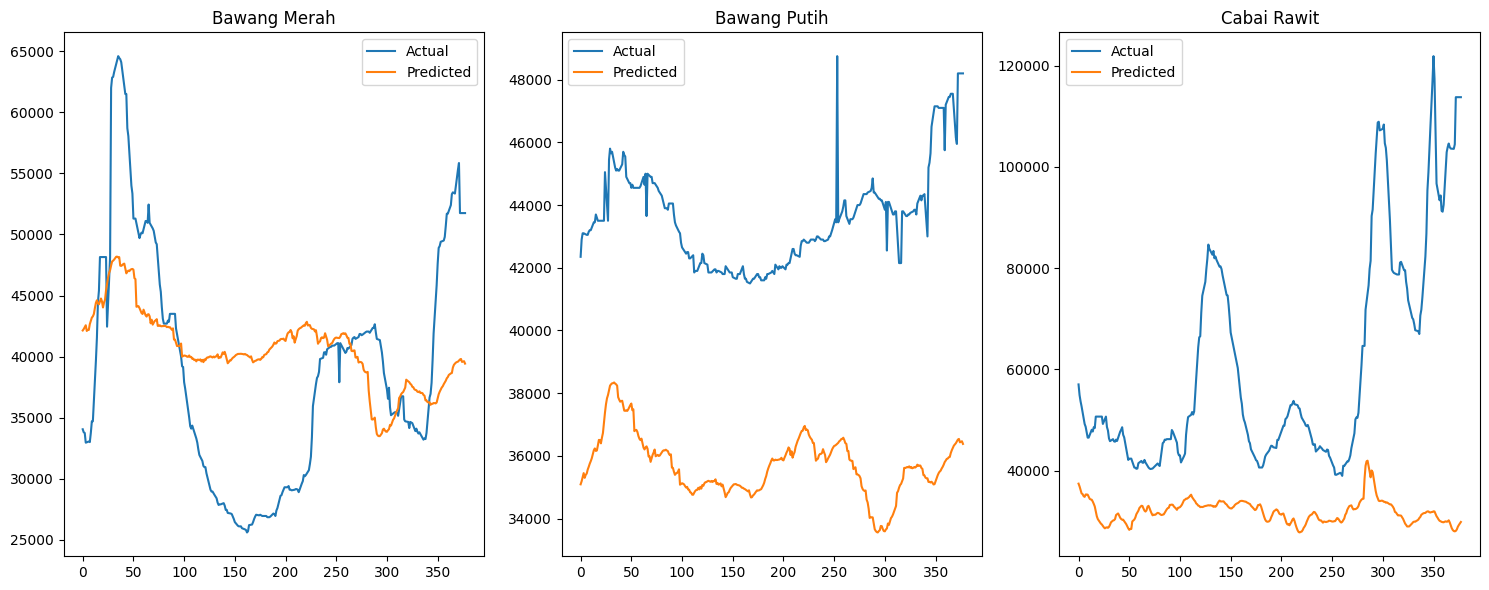

In [28]:
plt.figure(figsize=(15, 6))
for i, name in enumerate(target_cols):
    plt.subplot(1, 3, i+1)
    plt.plot(y_test_inv[:, i], label='Actual')
    plt.plot(y_pred_inv[:, i], label='Predicted')
    plt.title(name)
    plt.legend()
plt.tight_layout()
plt.show()